<Axes: >

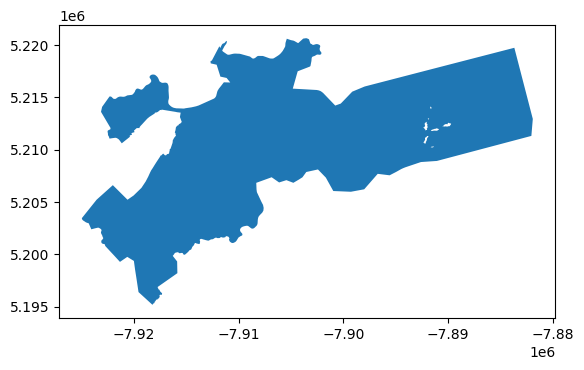

In [62]:
import osmnx as ox
import geopandas as gpd

# Get Boston city boundary
boston = ox.geocode_to_gdf("Boston, Massachusetts, USA")
boston = boston.to_crs(epsg=3857)  # Project for distance calculations

boston.plot()


In [63]:
tags = {
    "shop": ["supermarket", "grocery"]
}

groceries = ox.features_from_place(
    "Boston, Massachusetts, USA",
    tags=tags
)

# Keep only point geometries
groceries = groceries[groceries.geometry.type == "Point"]

# Project for distance/network analysis
groceries = groceries.to_crs(epsg=3857)

print(len(groceries))


37


In [64]:
import pandas as pd
from shapely.geometry import Point

stops = pd.read_csv("./MBTA_GTFS/stops.txt")

transit = gpd.GeoDataFrame(
    stops,
    geometry=[Point(xy) for xy in zip(stops.stop_lon, stops.stop_lat)],
    crs="EPSG:4326"
)

transit = transit.to_crs(epsg=3857)

# Clip to Boston
transit = gpd.overlay(transit, boston, how="intersection")


In [65]:
groceries["buffer"] = groceries.geometry.buffer(1000)
transit["buffer"] = transit.geometry.buffer(500)

grocery_buffer = gpd.GeoDataFrame(
    geometry=groceries["buffer"], crs=groceries.crs
)

transit_buffer = gpd.GeoDataFrame(
    geometry=transit["buffer"], crs=transit.crs
)


In [66]:
tracts = gpd.read_file("2020_Census_Tracts_in_Boston.shp")
tracts = tracts.to_crs(epsg=3857)


In [67]:
import requests
import pandas as pd

API_KEY = "139899cb1d77b4ad28212fbfe963f2b82b23d963"


url = (
    "https://api.census.gov/data/2020/acs/acs5"
    "?get=B01003_001E"
    "&for=tract:*"
    "&in=state:25&in=county:025"
    f"&key={API_KEY}"
)

response = requests.get(url)
data = response.json()

pop = pd.DataFrame(data[1:], columns=data[0])

pop = pop.rename(columns={
    "B01003_001E": "POPULATION"
})

pop["GEOID"] = (
    pop["state"] + pop["county"] + pop["tract"]
)

pop = pop[["GEOID", "POPULATION"]].astype({
    "POPULATION": int
})

pop.head()
tracts = tracts.rename(columns={"geoid20": "GEOID"})

tracts["GEOID"] = tracts["GEOID"].astype(str)

tracts = tracts.merge(
    pop,
    on="GEOID",
    how="left"
)



In [68]:
tracts["grocery_access"] = tracts.geometry.apply(
    lambda x: grocery_buffer.intersects(x).sum()
)

tracts["transit_access"] = tracts.geometry.apply(
    lambda x: transit_buffer.intersects(x).sum()
)

tracts["access_score"] = (
    tracts["grocery_access"] * 2 +
    tracts["transit_access"]
)

tracts["food_desert_risk"] = (
    tracts["POPULATION"] / (tracts["access_score"] + 1)
)


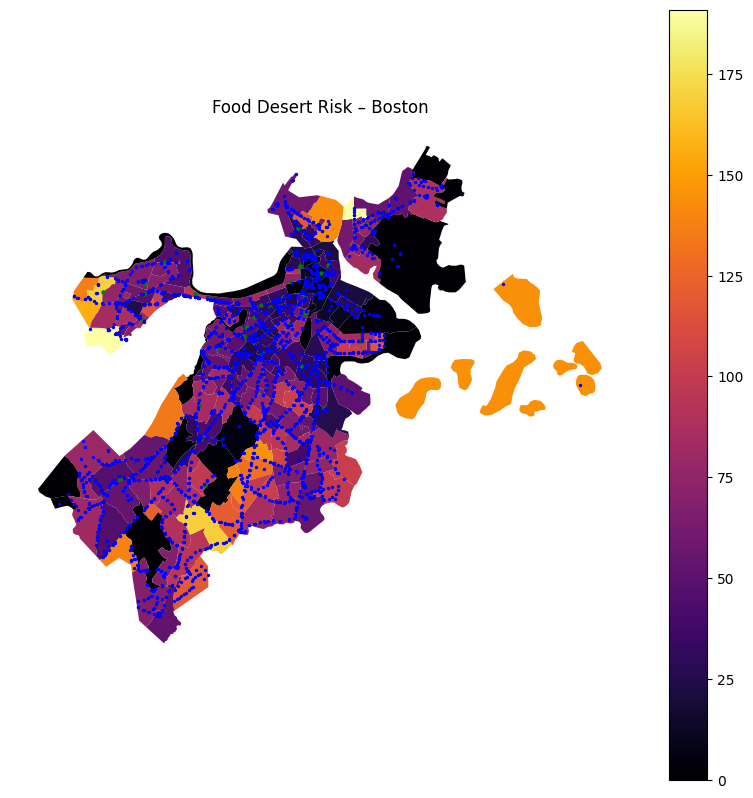

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

tracts.plot(
    column="food_desert_risk",
    cmap="inferno",
    legend=True,
    ax=ax
)

groceries.plot(ax=ax, color="green", markersize=5)
transit.plot(ax=ax, color="blue", markersize=2)

ax.set_title("Food Desert Risk – Boston")
ax.axis("off")

plt.show()


In [70]:
from scipy.stats import gaussian_kde
import numpy as np

coords = np.vstack([
    groceries.geometry.x,
    groceries.geometry.y
])

kde = gaussian_kde(coords)

tracts["grocery_density"] = tracts.centroid.apply(
    lambda p: kde([p.x, p.y])[0]
)


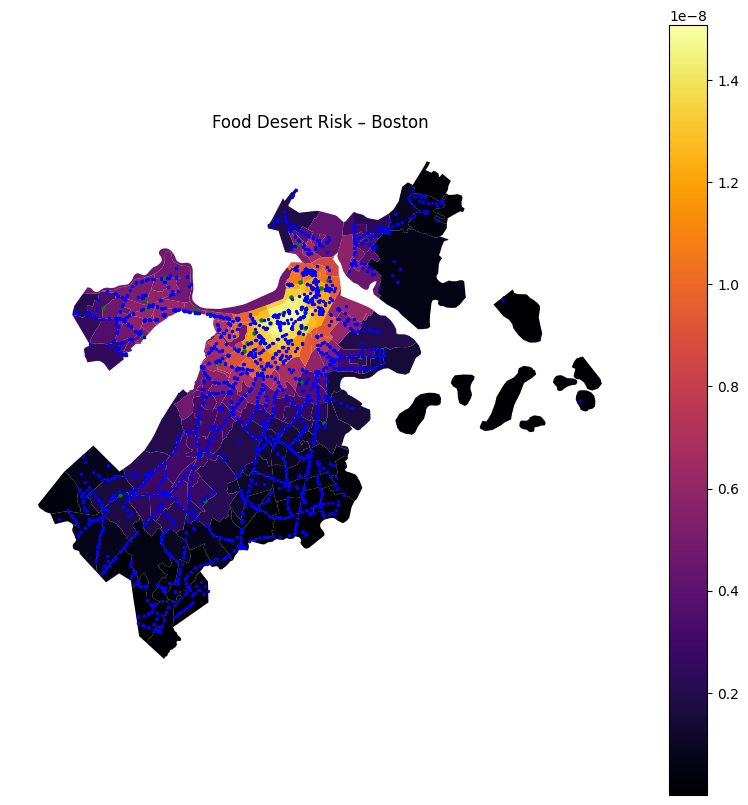

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

tracts.plot(
    column="grocery_density",
    cmap="inferno",
    legend=True,
    ax=ax
)

groceries.plot(ax=ax, color="green", markersize=5)
transit.plot(ax=ax, color="blue", markersize=2)

ax.set_title("Food Desert Risk – Boston")
ax.axis("off")

plt.show()


In [24]:
import osmnx as ox
import networkx as nx
import geopandas as gpd

# Get walkable street network
G = ox.graph_from_place(
    "Boston, Massachusetts, USA",
    network_type="walk"
)

# Project for distance-based routing
G = ox.project_graph(G)


In [72]:
meters_per_minute = 75  # conservative walking speed

for u, v, k, data in G.edges(keys=True, data=True):
    length = data.get("length", 0)
    data["travel_time"] = length / meters_per_minute


In [73]:
# groceries GeoDataFrame from earlier
groceries = groceries.to_crs(G.graph["crs"])

# Find nearest node for each grocery
groceries["nearest_node"] = groceries.geometry.apply(
    lambda x: ox.distance.nearest_nodes(G, x.x, x.y)
)


In [27]:
from shapely.geometry import Polygon
from shapely.ops import unary_union

def make_isochrone(G, center_node, trip_time):
    subgraph = nx.ego_graph(
        G,
        center_node,
        radius=trip_time,
        distance="travel_time"
    )

    nodes = [
        (data["x"], data["y"])
        for node, data in subgraph.nodes(data=True)
    ]

    return Polygon(nodes).convex_hull


In [28]:
isochrones = []

for node in groceries["nearest_node"]:
    poly = make_isochrone(G, node, trip_time=15)  # 15 min walk
    isochrones.append(poly)

isochrones_gdf = gpd.GeoDataFrame(
    geometry=isochrones,
    crs=G.graph["crs"]
)


In [74]:
grocery_access_area = unary_union(isochrones_gdf.geometry)

grocery_access_gdf = gpd.GeoDataFrame(
    geometry=[grocery_access_area],
    crs=isochrones_gdf.crs
)


In [75]:
tracts["covered"] = tracts.geometry.intersects(grocery_access_area)

tracts["food_desert"] = ~tracts["covered"]
tracts["at_risk_population"] = tracts["POPULATION"] * tracts["food_desert"].astype(int)


In [76]:
# Transit stops already snapped to network
transit["nearest_node"] = transit.geometry.apply(
    lambda x: ox.distance.nearest_nodes(G, x.x, x.y)
)

transit_isochrones = []

for node in transit["nearest_node"]:
    poly = make_isochrone(G, node, trip_time=5)
    transit_isochrones.append(poly)

transit_access = unary_union(transit_isochrones)

tracts["near_transit"] = tracts.geometry.intersects(transit_access)

tracts["adjusted_food_desert"] = (
    tracts["food_desert"] & ~tracts["near_transit"]
)


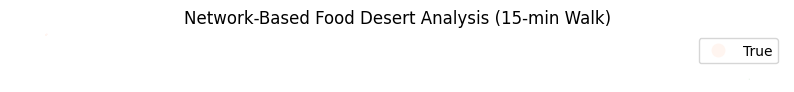

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

tracts.plot(
    column="adjusted_food_desert",
    cmap="Reds",
    legend=True,
    ax=ax
)

grocery_access_gdf.plot(
    ax=ax,
    color="green",
    alpha=0.3
)

ax.set_title("Network-Based Food Desert Analysis (15-min Walk)")
ax.axis("off")
plt.show()


In [51]:
import folium

tracts["covered_area"] = tracts.geometry.intersection(grocery_access_area).area
tracts["coverage_pct"] = tracts["covered_area"] / tracts.geometry.area


tracts_4326 = tracts.to_crs(epsg=4326)
groceries_4326 = groceries.to_crs(epsg=4326)
isochrones_4326 = isochrones_gdf.to_crs(epsg=4326)



In [52]:
m = folium.Map(
    location=[42.3601, -71.0589],
    zoom_start=12,
    tiles="cartodbpositron"  # clean, readable
)
folium.GeoJson(
    isochrones_4326,
    name="15-min Walk to Grocery",
    style_function=lambda x: {
        "fillColor": "green",
        "color": "green",
        "weight": 1,
        "fillOpacity": 0.25,
    },
).add_to(m)
folium.GeoJson(
    tracts_4326[
        tracts_4326["adjusted_food_desert"]
    ],
    name="Food Desert Tracts",
    style_function=lambda x: {
        "fillColor": "red",
        "color": "red",
        "weight": 1,
        "fillOpacity": 0.5,
    },
).add_to(m)

folium.Choropleth(
    geo_data=tracts_4326,
    name="Food Access (Coverage %)",
    data=tracts_4326,
    columns=["GEOID", "grocery_density"],
    key_on="feature.properties.GEOID",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Fraction of Tract Within 15-Min Walk",
).add_to(m)

for _, row in groceries_4326.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color="blue",
        fill=True,
        fill_opacity=0.8,
        popup=row.get("name", "Grocery Store"),
    ).add_to(m)

folium.GeoJson(
    tracts_4326,
    name="Tract Details",
    tooltip=folium.GeoJsonTooltip(
        fields=["GEOID", "POPULATION", "grocery_density"],
        aliases=["Tract:", "Population:", "Grocery Access %:"],
        localize=True
    ),
    style_function=lambda x: {
        "fillOpacity": 0,
        "color": "black",
        "weight": 0.3
    }
).add_to(m)



In [53]:
m.save("boston_food_desert_map.html")